# Ham Vs Spam Classification
---

## List of Imports

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import os
import re
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from mygraphs import histogram_top_n_words



## Globals

In [347]:
# Globals used throughout the project
#==================================================================================================

# seaborn darkgrid style
sns.set_style('darkgrid')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# List of email paths to load
email_paths = ['Data//easy_ham_1', 
               'Data//easy_ham_2', 
               'Data//hard_ham_1', 
               'Data//hard_ham_2', 
               'Data//spam_1', 
               'Data//spam_2']

# Regex patterns to match multi-line text block searches
block_regex_list = ['^(?!Subject:)[A-Z]\\S*:'] # Pattern to match any line that starts with a capital letter followed by a word and a colon

# Regex patterns to match whole line searches
line_regex_list = [
    r'From\s+.*@.*',                                       
    r'[A-Z].*?-.*?:',                                       
    r'^[A-Z].*?@.*?:',
    r'^--',                     # Pattern to match any line that starts with --
    r'^[\w\.-]+@[\w\.-]+',      # Pattern to match any line that starts with an email address
    r'^http',                   # Pattern to match any line that starts with https
    r'^.{0,9}http',             # Pattern to match any line that has http within the first 10 characters
    r'^\s*tests=.*',            # Pattern to match any line that starts with any number of whitespace then tests= then anything afterwards
    r'^\s*version=.*',          # Pattern to match any line that starts with any number of whitespace then version=
    r'^___.*',                  # Pattern to match any line that starts with ___
    r'.*[A-Z]+_[A-Z]+_.*',      # Pattern to match any line that has 3 or more words in all caps separated by _
    r'.*============.*',        # Pattern to match any line that has ============ in it
    r'.*------------.*'         # Pattern to match any line that has ------------ in it
]

# Regex patterns to match single expresion searches
single_regex_list = ['>', # Pattern to match any line that starts with >
                     r'\[\d\]', # Pattern to match any line that has a number in square brackets
                     r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', # Pattern to match any email address
                     r'www\.', # Pattern to match any line that starts with www.
                     r'http\.'
]



## Maximum False-Pos Rate Custom Classifier Class
- It is very important to minimize false positives (customers Ham going to their Spam folders and potentially missing important communication)
- Due to this business case, we are capping the models at 1% false positive rate
- Defined below is a custom classifier class to be used in pipelines to tune the thresholds of the models such that we can target a maximum false positive rate
- Additionally, we will be scoring Precision as our main metric, and scoring Accuracy secondarily

In [397]:
# Create a custom classifier that adjusts the threshold to achieve a target false positive rate
class ThresholdAdjuster(BaseEstimator):
    def __init__(self, base_estimator, max_fpr=0.15):
        '''
        Parameters: base_estimator - a trained model
                    max_fpr - the target false positive rate
        '''
        self.base_estimator = base_estimator
        self.max_fpr = max_fpr
        self.threshold_calculated = False

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        if not self.threshold_calculated:
            self.adjust_threshold_for_fpr(X, y)
        return self
    
    def predict(self, X):
        probabilities = self.base_estimator.predict_proba(X)
        return (probabilities[:, 1] > self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
        
    def adjust_threshold_for_fpr(self, X, y_true, verbose=False):
        '''
        Parameters: X - a matrix of features
                    y_true - the true labels
        Returns: None

        Adjusts the threshold of the model to achieve a target false positive rate
        '''
        verbose = True
        # get the predicted probabilities
        y_test_prob = self.predict_proba(X)[:, 1]
        threshold = 0
        fpr = 1
        # loop until the false positive rate is less than target_fpr
        while fpr > self.max_fpr:
            # increase the threshold
            threshold += 0.001
            # get the predicted values
            y_pred = (y_test_prob > threshold).astype(int)     
            # calculate the false positive rate
            cm = confusion_matrix(y_true, y_pred)
            fpr = cm[0, 1] / cm[0].sum()
        if verbose:
            print(f'Threshold: {threshold:.3f}, FPR: {fpr:.3f}')
        self.threshold = threshold
        self.threshold_calculated = True
   

## Create a report function to be used on all models
- also stores the model names, model and results in a dictionary for final evaluations

In [370]:
# define a function to display the results of a model
def display_results(model_name, data_name, pipeline, X_train, y_train, X_test, y_test):
    '''
    Parameters: model_name - the name of the model
                pipeline - the trained pipeline
                X_train - the training features
                y_train - the training labels
                X_test - the test features
                y_test - the test labels
    Returns: None

    Displays the results of the model
    '''
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_pred)
    model_results[model_name] = {'Data Set': data_name,
                                 'Pipeline': pipeline,
                                 'Train Accuracy': train_accuracy,
                                 'CV Accuracy': cv_score, 
                                 'Accuracy': accuracy, 
                                 'Precision': precision, 
                                 'Recall': recall, 
                                 'F1': f1, 
                                 'AUC': auc}
    print(f'Model: {model_name}')
    print('='*50)
    print(f'         Train Accuracy: {train_accuracy:.4f}')
    print(f'            CV Accuracy: {cv_score:.4f}')
    print(f'               Accuracy: {accuracy:.4f}')
    print(f'              Precision: {precision:.4f}')
    print(f'                 Recall: {recall:.4f}')
    print(f'                     F1: {f1:.4f}')
    print(f'                    AUC: {auc:.4f}')
    print('='*50)
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
    disp.plot()
    plt.grid(False)
    plt.show()
    return

# function to Create a dataframe to display the results of all models
def display_results_df():
    results_df = pd.DataFrame(model_results).T
    results_df.drop('Pipeline', axis=1, inplace=True)
    results_df.sort_values('Precision', ascending=False, inplace=True)
    return results_df


---

## Load in the Email Data from Individual HTML Files

### Helper functions used during the importing and initial cleaning of email files

In [350]:
def load_emails(path_list):
    '''
    Parameters: path_list - a list of paths to the email files
    Returns: a list of strings, each string is the content of an email file
             a list of integers, each integer is the target of an email file
                (1 for spam, 0 for not spam)

    Load the content of each email file in path_list in HTML format, 
    and return a list of strings
    '''
    emails = []
    target = []
    # loop through all the files in the folder
    for path in path_list:
        for file in os.listdir(path):
            # open the file
            with open(path + '//' + file, 'r') as f:
                # try to read the file
                try:
                    data = f.read()
                    # check if the email is spam or not
                    if 'spam' in path:
                        target.append(1)
                    else:
                        target.append(0)
                except UnicodeDecodeError:
                    continue
                # parse the file
                soup = BeautifulSoup(data, 'html.parser')
                # extract the text
                emails.append(soup.get_text())
    return emails, target


In [351]:
def strip_block(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with blocks of text removed

    Removes a line of from text that starts with keyword and each subsequent line 
    that starts with whitespace. This is useful for removing email headers.
    '''

    # initialize a flag to keep track of whether we are inside a block
    inside = False
    # split the text into lines
    lines = text.split('\n')
    # initialize a new list to hold the lines we want to keep
    new_lines = []
    # loop through the lines
    for line in lines:
        # check if the matches any keyword or we inside a block
        for keyword in keyword_list:
            if re.match(keyword, line) or (inside and re.match(r'^\s+', line)):
                inside = True
                break
            else:   # if we aren't, add it to the new list
                new_lines.append(line)
                inside = False

    # join the new lines together with a newline character
    return '\n'.join(new_lines)



In [352]:
def strip_line(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with lines of text removed

    Removes lines of from text that contains a keyword anywhere in the line
    '''
    # Split the text into lines
    text = text.split('\n')
    # Remove any lines that contain a keyword
    text = [line for line in text if not any(re.match(pattern, line) for pattern in keyword_list)]
    # Join the lines back together
    text = '\n'.join(text)
    return text

In [353]:
def strip_expression(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with expressions removed

    Removes expressions from text that matches the regex patterns in keyword_list
    '''


    for exp in keyword_list:
        # strip the occurance that matches the regex patterns in strip_list
        text = re.sub(exp, '', text)
    return text

In [354]:
def clean_raw_email(text, block_regex_list, line_regex_list, single_regex_list):
    '''
    Parameters: text - a string of text
                block_regex_list - a list of regular expressions
                line_regex_list - a list of regular expressions
                single_regex_list - a list of regular expressions
    Returns: a string of text with blocks, lines and expressions removed

    Removes blocks, lines and expressions from text that matches the regex patterns in block_regex_list, line_regex_list and single_regex_list
    '''
    text = strip_block(text, block_regex_list)
    text = strip_line(text, line_regex_list)
    text = strip_expression(text, single_regex_list)
    return text

In [355]:
def pop_subject(text):
    '''
    Parameters: text - a string of text (email)
    Returns: the text with the subject removed as a string
              the subject as a string
    '''
    # split the text into lines
    lines = text.split('\n')
    # initialize the subject string (in case we don't find it)
    subject = ''
    # find the first line that starts with 'Subject:'
    for i, line in enumerate(lines):
        if line.startswith('Subject:'):
            subject = line
            break
    # remove the subject from the text
    text = '\n'.join(lines[i+1:])
    # remove the 'Subject:' from the subject string
    subject = subject.replace('Subject:', '')
    return text, subject

In [356]:
def create_email_df(email_paths):
    '''
    Parameters: email_paths - a list of paths to the email files
    Returns: a DataFrame with the email body, subject and target as columns

    Load the content of each email file in email_paths in HTML format,
    clean the emails by removing blocks, lines and expressions that match 
    the regex patterns in block_regex_list, line_regex_list and single_regex_list
    and return a DataFrame with the emails and targets in random order
    '''
    emails, target = load_emails(email_paths)
    emails_cleaned = [clean_raw_email(email, block_regex_list, line_regex_list, single_regex_list) for email in emails]
    body, subject = [], []
    for email in emails_cleaned:
        body_, subject_ = pop_subject(email)
        body.append(body_)
        subject.append(subject_)
    body_df = pd.DataFrame(body, columns=['body'])
    subject_df = pd.DataFrame(subject, columns=['subject'])
    target_df = pd.DataFrame(target, columns=['target'])
    raw_df = pd.concat([subject_df, body_df,target_df], axis=1)
    raw_df = raw_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return raw_df

### Load the email data into a dataframe, preliminary EDA and cleaning

In [357]:
emails_df = create_email_df(email_paths)

In [358]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  5825 non-null   object
 1   body     5825 non-null   object
 2   target   5825 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 136.6+ KB


ANALYSIS
- There are no NaN

In [359]:
# Check for emails with empty subject and body
emails_df[(emails_df['subject'] == '') & (emails_df['body'] == '')].count()

subject    109
body       109
target     109
dtype: int64

ANALYSIS:
- There are 109 rows that have empty strings for both the subject and body, lets get rid of them

In [360]:
emails_df = emails_df[(emails_df['subject'] != '') | (emails_df['body'] != '')]
# reset the index
emails_df = emails_df.reset_index(drop=True)

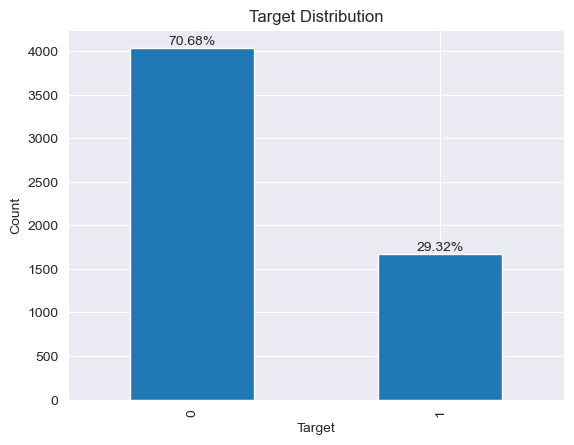

In [361]:
# Check the target distribution
emails_df['target'].value_counts()

# create a bargraph of the target distribution
emails_df['target'].value_counts().plot(kind='bar')

# add title and labels
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

# add percentages to the bars
for i, count in enumerate(emails_df['target'].value_counts()):
    plt.text(i, count, f'{count/len(emails_df)*100:.2f}%', ha='center', va='bottom')

# show the plot
plt.show()

ANALYSIS:
- The target class distribution is not even, will have to deal with this during modeling

In [362]:
# Create separate dataframes for the subject and body so they can be analyzed and modeled separately
subject_df = emails_df.drop('body', axis=1)
body_df = emails_df.drop('subject', axis=1)

---

## Email-Subject


### Cleaning and EDA

In [363]:
# Create a copy of the subject dataframe for EDA
subject_eda_df = subject_df.copy()

# Lowercase the subject column
subject_eda_df['subject'] = subject_eda_df['subject'].apply(lambda x: str.lower(x))

# Tokenize the subject column
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
subject_eda_df['subject_tokenized'] = subject_eda_df['subject'].apply(lambda x: tokenizer.tokenize(x))


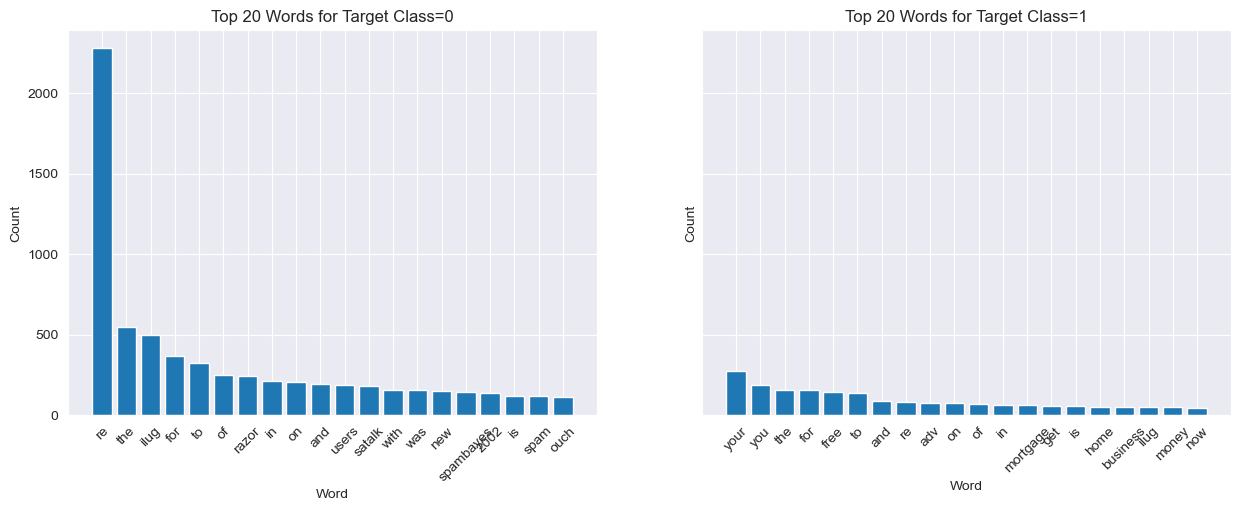

In [364]:
# visualize the top 20 words in the subject column for spam and not spam
histogram_top_n_words(subject_eda_df, 20, 'target')

ANALYSYS:
- Very strong signal on 're'; will need to consider removing re to simulate a more realistic spam situation as this might make it too easy
- The ham emails seem to be inter-company and many subject lines contain jargon words like spambayes (they were most likely testing thier spam filters), razor, etc.  We should also consider removing these to simulate a more realistic filtering situation in the wild.

In [365]:
# Remove stopwords and cheating words from the tokenized subject column
def remove_stopwords(token_list, stopwords_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [token for token in token_list if token not in stopwords_list]

cheat_words = ['re', 'razor', 'spamassassin', 'spam', 'assassin', 'spambayes', 'satalk', 'ilug', 'zzzzteana']    
stop_words = stopwords.words('english')
for word in cheat_words:
    stop_words.append(word)

subject_eda_df['subject_tokenized'] = subject_eda_df['subject_tokenized'].apply(lambda x: remove_stopwords(x, stop_words))
               

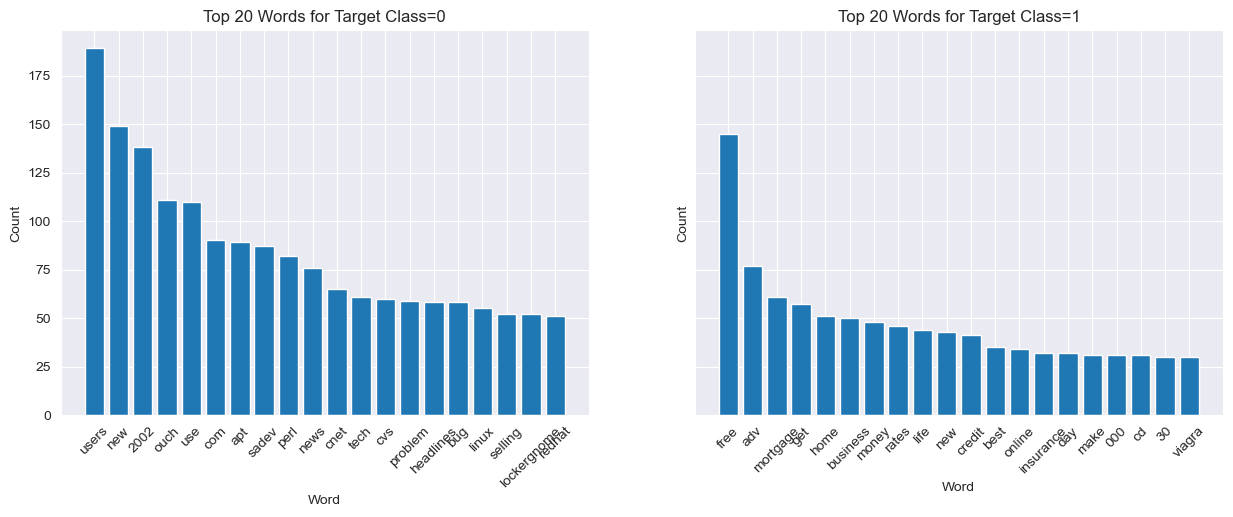

In [366]:
# visualize the top 20 words in the subject with stopwords and cheating words removed
histogram_top_n_words(subject_eda_df, 20, 'target')

ANALYSIS:
- Looks a little more realistic. We will run the model with and without 'cheatwords'

---

## Preprocessing and Modeling

In [367]:
# Create our train and test sets
X = subject_df['subject']
y = subject_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
### Baseline Model:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Multinomial Bayes Classifier

In [398]:
# Create a tokenizer function and a vectorizer pipeline step for basic preprocessing

# Define the baseline tokenizer function
def baseline_tokenizer(text):
    '''
    Parameters: text - a string of text
    Returns: a list of words that are at least 3 characters long
    '''
    tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
    return tokenizer.tokenize(text)

# define the stopwords to use in the vectorizer
stop_words = stopwords.words('english')

# Create the baseline basic binary CountVectorizer pipeline step tuple
step_basic_vec = ('binary_vec', CountVectorizer(max_features=1000,
                                           binary=True, 
                                           stop_words=stop_words, 
                                           tokenizer=baseline_tokenizer))

# Instantiate baseline model and maximum false positive rate = 1%
baseline_clf = MultinomialNB(fit_prior=True)
step_baseline_model = ('clf', ThresholdAdjuster(baseline_clf, 
                                                max_fpr=0.01))

# Create and fit the pipeline for the baseline model
pipe_baseline = Pipeline([step_basic_vec, step_baseline_model])

pipe_baseline.fit(X_train, y_train)

Threshold: 0.839, FPR: 0.010


Pipeline(steps=[('basic',
                 CountVectorizer(binary=True, max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function baseline_tokenizer at 0x000001B94E3C29D0>)),
                ('clf',
                 ThresholdAdjuster(base_estimator=MultinomialNB(),
                                   max_fpr=0.01))])

Threshold: 0.807, FPR: 0.010
Threshold: 0.819, FPR: 0.009
Threshold: 0.871, FPR: 0.009
Threshold: 0.827, FPR: 0.009
Threshold: 0.809, FPR: 0.009
Model: Baseline Model (MultinomialNB)
         Train Accuracy: 0.8898
            CV Accuracy: 0.8629
               Accuracy: 0.8584
              Precision: 0.9208
                 Recall: 0.5602
                     F1: 0.6966
                    AUC: 0.7703
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       812
           1       0.92      0.56      0.70       332

    accuracy                           0.86      1144
   macro avg       0.88      0.77      0.80      1144
weighted avg       0.87      0.86      0.85      1144



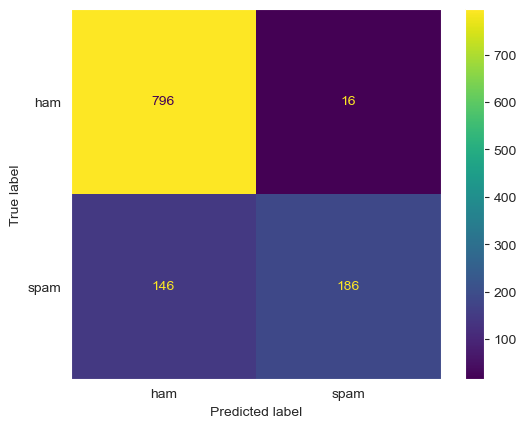

In [399]:
model_results = {}
display_results('Baseline Model (MultinomialNB)', 'Email-Subject', pipe_baseline, X_train, y_train, X_test, y_test)

ANALYSIS:
- Pretty good for minimal baseline processing with maximum training FPR=1%; Precision=0.92, Accuracy=0.86
- Nearly half of the Spam goes to Ham, but more importantly only 16 (2%) Ham goes to Spam
- The baseline accuracy on the test set is better than the training cross-val score, so not overfitted

---

### ComplementNB Model:
- Same preprocessing as the baseline
- Complement NB might do better on unbalanced class distribution (we are at 70/30)

In [400]:
# Create the ComplementNB model pipeline step tuple
class_prior = [0.7, 0.3]
compNB_clf = ComplementNB(class_prior=class_prior)

step_compNB_clf = ('clf', ThresholdAdjuster(compNB_clf, 
                                            max_fpr=0.01))

# Create and fit the pipeline for the baseline model
pipe_combNB_basic = Pipeline([step_basic_vec, step_compNB_clf])

pipe_combNB_basic.fit(X_train, y_train)

Threshold: 0.926, FPR: 0.010


Pipeline(steps=[('basic',
                 CountVectorizer(binary=True, max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function baseline_tokenizer at 0x000001B94E3C29D0>)),
                ('clf',
                 ThresholdAdjuster(base_estimator=ComplementNB(class_prior=[0.7,
                                                                            0.3]),
                                   max_fpr=0.01))])

Threshold: 0.908, FPR: 0.010
Threshold: 0.916, FPR: 0.009
Threshold: 0.942, FPR: 0.009
Threshold: 0.921, FPR: 0.009
Threshold: 0.913, FPR: 0.009
Model: ComplementNB Basic
         Train Accuracy: 0.8898
            CV Accuracy: 0.8631
               Accuracy: 0.8584
              Precision: 0.9208
                 Recall: 0.5602
                     F1: 0.6966
                    AUC: 0.7703
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       812
           1       0.92      0.56      0.70       332

    accuracy                           0.86      1144
   macro avg       0.88      0.77      0.80      1144
weighted avg       0.87      0.86      0.85      1144



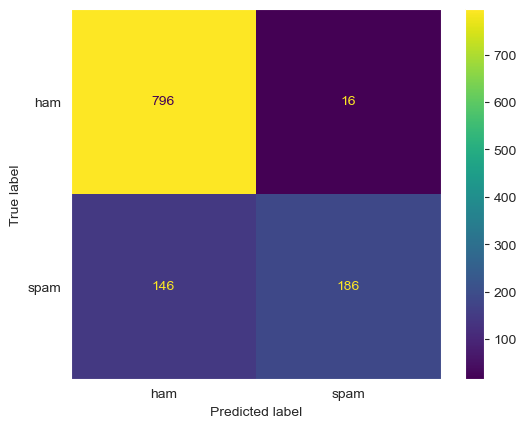

In [401]:
# Display the results of the ComplementNB model
display_results('ComplementNB Basic', 'Email-Subject', pipe_combNB_basic, X_train, y_train, X_test, y_test)

In [402]:
display_results_df()

,Data Set,Train Accuracy,CV Accuracy,Accuracy,Precision,Recall,F1,AUC
Baseline Model (MultinomialNB),Email-Subject,0.889764,0.862857,0.858392,0.920792,0.560241,0.696629,0.770268
ComplementNB Basic,Email-Subject,0.889764,0.863076,0.858392,0.920792,0.560241,0.696629,0.770268


ANALYSIS:
- Even though it should do better with imbalanced classes, Complement NB did the same as the baseline model

---


---
### Multinomial Bayes with Count Vectorization:
- Basic tokenizer of >2 characters
- Count vectorizer
- Multinomial Bayes Classifier (same params as baseline)

In [403]:
# Create a tokenizer function and a vectorizer pipeline step for basic preprocessing


# Create the baseline basic binary CountVectorizer pipeline step tuple
step_count_vec = ('step_vec', CountVectorizer(max_features=1000,
                                           binary=False, 
                                           stop_words=stop_words, 
                                           tokenizer=baseline_tokenizer))

# Create and fit the pipeline for the baseline model
pipe_baseline = Pipeline([step_count_vec, step_baseline_model])

pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('basic',
                 CountVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function baseline_tokenizer at 0x000001B94E3C29D0>)),
                ('clf',
                 ThresholdAdjuster(base_estimator=MultinomialNB(),
                                   max_fpr=0.01))])

Threshold: 0.832, FPR: 0.009
Threshold: 0.828, FPR: 0.009
Threshold: 0.878, FPR: 0.010
Threshold: 0.840, FPR: 0.010
Threshold: 0.851, FPR: 0.010
Model: MultinomialNB Count-Vectorized)
         Train Accuracy: 0.8898
            CV Accuracy: 0.8618
               Accuracy: 0.8601
              Precision: 0.9216
                 Recall: 0.5663
                     F1: 0.7015
                    AUC: 0.7733
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       812
           1       0.92      0.57      0.70       332

    accuracy                           0.86      1144
   macro avg       0.88      0.77      0.81      1144
weighted avg       0.87      0.86      0.85      1144



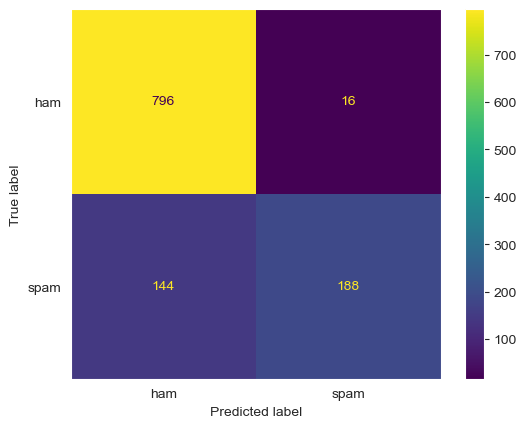

In [404]:
display_results('MultinomialNB Count-Vectorized)', 'Email-Subject', pipe_baseline, X_train, y_train, X_test, y_test)

In [405]:
display_results_df()

,Data Set,Train Accuracy,CV Accuracy,Accuracy,Precision,Recall,F1,AUC
MultinomialNB Count-Vectorized),Email-Subject,0.889764,0.861763,0.86014,0.921569,0.566265,0.701493,0.77328
Baseline Model (MultinomialNB),Email-Subject,0.889764,0.862857,0.858392,0.920792,0.560241,0.696629,0.770268
ComplementNB Basic,Email-Subject,0.889764,0.863076,0.858392,0.920792,0.560241,0.696629,0.770268


ANALYSIS:
- Count vectorized is slightly better precision but in the noise probably.
- Makes sense as the subject line is usually pretty sparse on words, so counts will not be much different than binary values

---

---
### Multinomial Bayes with TF-IDF Vectorization:
- Basic tokenizer of >2 characters
- TF-IDF vectorizer
- Multinomial Bayes Classifier (same params as baseline)

In [407]:

step_tfidf_vec = ('tf_idf', TfidfVectorizer(max_features=1000,
                                           stop_words=stop_words, 
                                           tokenizer=baseline_tokenizer))

# Create and fit the pipeline for the baseline model
pipe_baseline = Pipeline([step_tfidf_vec, step_baseline_model])

pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function baseline_tokenizer at 0x000001B94E3C29D0>)),
                ('clf',
                 ThresholdAdjuster(base_estimator=MultinomialNB(),
                                   max_fpr=0.01))])

Threshold: 0.667, FPR: 0.009
Threshold: 0.643, FPR: 0.009
Threshold: 0.668, FPR: 0.010
Threshold: 0.646, FPR: 0.010
Threshold: 0.625, FPR: 0.010
Model: MultinomialNB TF-IDF-Vectorized)
         Train Accuracy: 0.8406
            CV Accuracy: 0.8692
               Accuracy: 0.8156
              Precision: 0.9764
                 Recall: 0.3735
                     F1: 0.5403
                    AUC: 0.6849
              precision    recall  f1-score   support

           0       0.80      1.00      0.88       812
           1       0.98      0.37      0.54       332

    accuracy                           0.82      1144
   macro avg       0.89      0.68      0.71      1144
weighted avg       0.85      0.82      0.78      1144



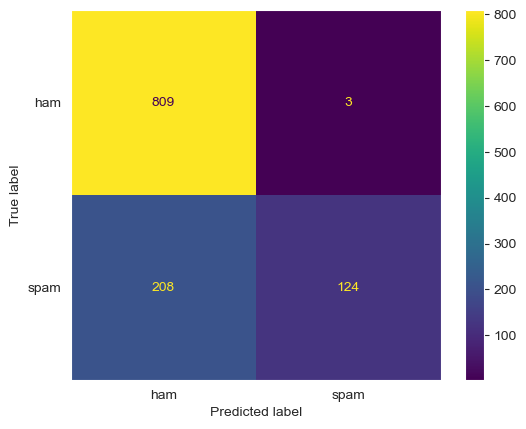

In [408]:
display_results('MultinomialNB TF-IDF-Vectorized)', 'Email-Subject', pipe_baseline, X_train, y_train, X_test, y_test)

In [409]:
display_results_df()

,Data Set,Train Accuracy,CV Accuracy,Accuracy,Precision,Recall,F1,AUC
MultinomialNB TF-IDF-Vectorized),Email-Subject,0.840551,0.869202,0.815559,0.976378,0.373494,0.540305,0.6849
MultinomialNB Count-Vectorized),Email-Subject,0.889764,0.861763,0.86014,0.921569,0.566265,0.701493,0.77328
Baseline Model (MultinomialNB),Email-Subject,0.889764,0.862857,0.858392,0.920792,0.560241,0.696629,0.770268
ComplementNB Basic,Email-Subject,0.889764,0.863076,0.858392,0.920792,0.560241,0.696629,0.770268


ANALYSIS:
- Much higher precision at .98, but our accuracy suffered now at .82.  
- Now the majority of spam is classifying into ham... not good

---

### Random Forest Classifier
- Same preprocessing as the baseline
- Complement NB might do better on unbalanced class distribution (we are at 70/30)

In [385]:
# Create the ComplementNB model pipeline step tuple
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)

step_rf_clf = ('rf_clf', ThresholdAdjuster(rf_clf, 
                                            max_fpr=0.01))

# Create and fit the pipeline for the baseline model
pipe_rf_clf_basic = Pipeline([step_basic_vec, step_rf_clf])

pipe_rf_clf_basic.fit(X_train, y_train)

Threshold: 0.434, FPR: 0.010


Pipeline(steps=[('basic',
                 CountVectorizer(binary=True, max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function baseline_tokenizer at 0x000001B94E4B93A0>)),
                ('rf_clf',
                 ThresholdAdjuster(base_estimator=RandomForestClassifier(n_estimators=1000,
                                                                         random_state=42),
                                   max_fpr=0.01))])

Threshold: 0.397, FPR: 0.009
Threshold: 0.437, FPR: 0.010
Threshold: 0.426, FPR: 0.009
Threshold: 0.458, FPR: 0.010
Threshold: 0.398, FPR: 0.009
Model: RandomForest Basic
         Train Accuracy: 0.9617
            CV Accuracy: 0.8871
               Accuracy: 0.8864
              Precision: 0.8483
                 Recall: 0.7410
                     F1: 0.7910
                    AUC: 0.8434
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       812
           1       0.85      0.74      0.79       332

    accuracy                           0.89      1144
   macro avg       0.87      0.84      0.86      1144
weighted avg       0.88      0.89      0.88      1144



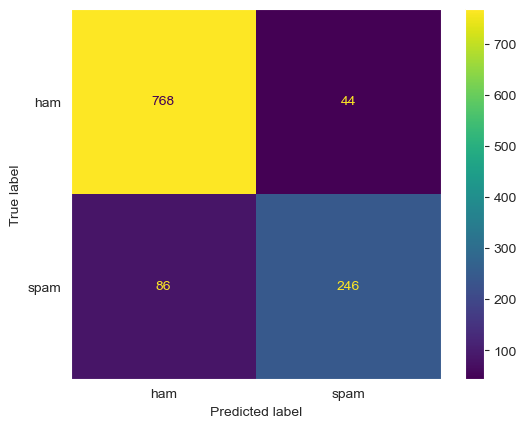

In [386]:
# Display the results of the ComplementNB model
display_results('RandomForest Basic', 'Email-Subject', pipe_rf_clf_basic, X_train, y_train, X_test, y_test)

In [380]:
display_results_df()

,Data Set,Train Accuracy,CV Accuracy,Accuracy,Precision,Recall,F1,AUC
Baseline Model (MultinomialNB),Email-Subject,0.889764,0.862857,0.858392,0.920792,0.560241,0.696629,0.770268
ComplementNB Basic,Email-Subject,0.889764,0.863076,0.858392,0.920792,0.560241,0.696629,0.770268
RandomForest Basic,Email-Subject,0.961505,0.886701,0.882867,0.841379,0.73494,0.784566,0.839145


ANALYSIS:
- Even though it should do better with imbalanced classes, Complement NB did the same as the baseline model